In [1]:
import torch
import torchinfo
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import confusion_matrix

import dsutils 


import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [35]:
## Load some pretrained models

In [2]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet152.eval().to(device)
resnet50.eval().to(device)
resnet34.eval().to(device)
resnet18.eval().to(device)
alexnet.eval().to(device)

Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
# filenames for imagenet sample images

fnames = os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test')

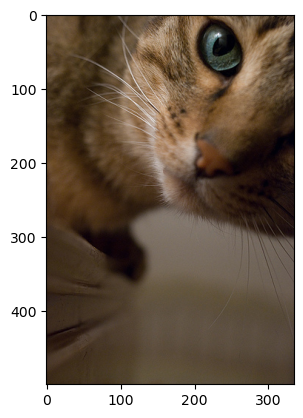

In [4]:
# Show an image

trial_image = fnames[11]
input_image = Image.open('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test/'+ trial_image)

plt.imshow(input_image)

In [5]:
# Define preprocessing 
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# preprocess one image
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [7]:
# Test a model (run forward pass with test image)

with torch.no_grad():
    output = torch.nn.functional.softmax(alexnet(input_batch), dim=1)

results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('tabby, tabby cat', '19.7%'), ('Egyptian cat', '17.3%'), ('tiger cat', '17.2%')]


In [ ]:
## Extract Jacobians between the output and intermediate layers

In [68]:
# Extract the Jacobian

# AlexNet

# class Flatten(nn.Module):
#     def __init__(self):
#         super(Flatten, self).__init__()
        
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         return x



# class SoftMaxModule(nn.Module):
#     def __init__(self, dim):
#         super(SoftMaxModule, self).__init__()
#         self.softmax = nn.Softmax(dim=dim)

#     def forward(self, x):
#         return self.softmax(x)

# class SoftMaxModule(nn.Module):
#     def __init__(self):
#         super(SoftMaxModule, self).__init__()
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         return self.softmax(x)

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

# alexnet_part1 = nn.Sequential(*list(alexnet.features.children()))
# alexnet_part2 = alexnet.avgpool
# alexnet_part3 = nn.Sequential(*list(alexnet.classifier.children()))

module1 = list(alexnet.children())[:1]
module2 = list(alexnet.children())[1:2]

# anet_1st = nn.Sequential(*module1)

anet_1st = nn.Sequential(*[*module1, *module2, dsutils.Flatten()])

# anet_2nd = nn.Sequential(*[list(alexnet.children())[-1]])
anet_2nd = nn.Sequential(*[list(alexnet.children())[-1], dsutils.SoftMaxModule() ])

# anet_2nd = nn.Sequential(*module2)



with torch.no_grad():
    for inputs, _ in trainloader:
#         inputs, labels = data
        # x1 = alexnet_part1(inputs)
        # x2 = alexnet_part2(x1)
        # x3 = alexnet_part3(x2)
        x1 = anet_1st(inputs)
        x2 = anet_2nd(x1) 
        # output = torch.nn.functional.softmax(x2, dim=1) # check classifications
        
        # output = torch.nn.functional.softmax(alexnet(inputs), dim=1) # check classifications
        # firstlayer = alexnet.features[0:4](inputs)

# jacobian = torch.autograd.functional.jacobian(anet_2nd, x1)


In [81]:
x2.shape[0]

1029

In [70]:
Js_anet = []
for i in np.arange(x2.shape[0]):
    jacobian_anet = torch.autograd.functional.jacobian(anet_2nd, x1[i,:])
    Js_anet.append(jacobian_anet)

In [82]:
np.arange(x2.shape[0])

array([   0,    1,    2, ..., 1026, 1027, 1028])

In [71]:
jacobian_anet.shape

torch.Size([1000, 9216])

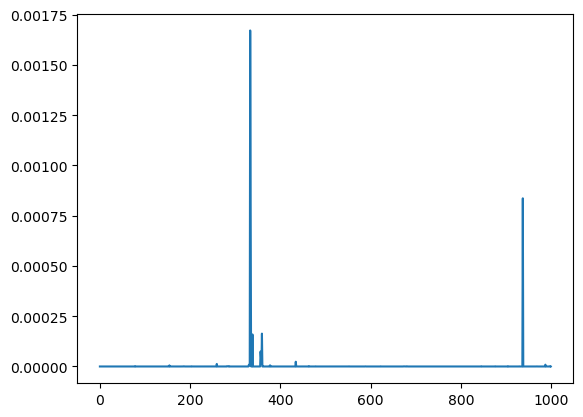

In [72]:
plt.plot(np.linalg.norm(jacobian_anet.numpy(),axis=1))

In [73]:
results = utils.pick_n_best(predictions=x2, n=3)

sample 0: [('tench, Tinca tinca', '97.6%'), ('banded gecko', '1.5%'), ('sturgeon', '0.4%')]
sample 1: [('goldfish, Carassius auratus', '100.0%'), ('tench, Tinca tinca', '0.0%'), ('rock beauty, Holocanthus tricolor', '0.0%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '86.8%'), ('tiger shark, Galeocerdo cuvieri', '3.7%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '2.3%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '99.5%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.3%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 4: [('swimming trunks, bathing trunks', '91.7%'), ('sarong', '4.4%'), ('bikini, two-piece', '0.8%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '98.3%'), ('stingray', '1.6%'), ('muzzle', '0.0%')]
sample 6: [('stingray', '60.8%'), ('electric ray, crampfish, numbfish, torpedo', '36.8%'), ('sea slug, nudibranch', '0.9%

In [74]:
# Extract the Jacobian

# ResNet

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

# alexnet_part1 = nn.Sequential(*list(alexnet.features.children()))
# alexnet_part2 = alexnet.avgpool
# alexnet_part3 = nn.Sequential(*list(alexnet.classifier.children()))

module1 = list(resnet50.children())[:6]
module2 = list(resnet50.children())[6:]

# anet_1st = nn.Sequential(*module1)

rnet50_1st = nn.Sequential(*[*module1, dsutils.Flatten()])

# anet_2nd = nn.Sequential(*[list(alexnet.children())[-1]])
rnet50_2nd = nn.Sequential(*[*module2, dsutils.SoftMaxModule() ])

# anet_2nd = nn.Sequential(*module2)



with torch.no_grad():
    for inputs, _ in trainloader:
#         inputs, labels = data
        # x1 = alexnet_part1(inputs)
        # x2 = alexnet_part2(x1)
        # x3 = alexnet_part3(x2)
        y1 = rnet50_1st(inputs)
        y2 = rnet50_2nd(y1) 
        # output = torch.nn.functional.softmax(x2, dim=1) # check classifications
        
        output = torch.nn.functional.softmax(resnet50(inputs), dim=1) # check classifications
        # firstlayer = alexnet.features[0:4](inputs)

# jacobian = torch.autograd.functional.jacobian(anet_2nd, x1)


In [75]:
y2.shape

torch.Size([1029, 1000])

In [76]:
jacobian_rnet50 = torch.autograd.functional.jacobian(rnet50_2nd, y1[333,:])

In [77]:
jacobian_rnet50.shape 

torch.Size([1000, 2048])

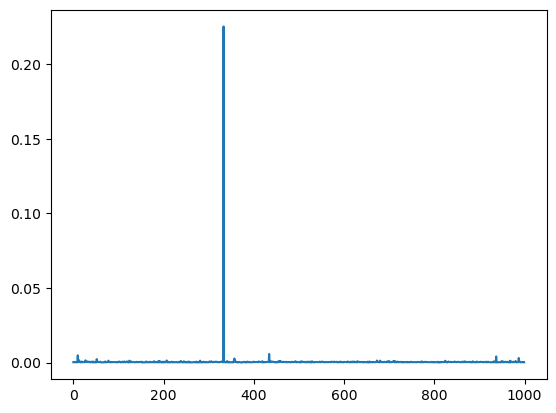

In [78]:
plt.plot(np.linalg.norm(jacobian_rnet50.numpy(),axis=1))

In [79]:
import metrics

A = jacobian_anet@jacobian_anet.T
B = jacobian_rnet50@jacobian_rnet50.T

db2 = metrics.sq_bures_metric(A.numpy(),B.numpy())

In [80]:
db2

np.float32(0.05029094)

In [ ]:
# To do:

# figure out what to do with conv layers 
# 